# Wstęp


## Wybrany temat

todo


## Pobieranie danych

todo


In [106]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import datetime

In [107]:
def scrap_tweets(max_tweets_per_day, date_from, date_to):
    tweets = []

    date_from_2 = date_from + datetime.timedelta(days=1)

    while date_from != date_to:
        query = f'#fifaworldcup lang:en since:{date_from} until:{date_from_2}'
        new_tweets = []
        for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
            new_tweets.append(tweet)

            if len(new_tweets) >= max_tweets_per_day:
                break

        if len(new_tweets) < max_tweets_per_day:
            query = f'#worldcup lang:en since:{date_from} until:{date_from_2}'
            for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
                new_tweets.append(tweet)

                if len(new_tweets) >= max_tweets_per_day:
                    break

        if len(new_tweets) < max_tweets_per_day:
            query = f'#wc lang:en since:{date_from} until:{date_from_2}'
            for _, tweet in enumerate(sntwitter.TwitterHashtagScraper(query, maxEmptyPages=5).get_items()):
                new_tweets.append(tweet)

                if len(new_tweets) >= max_tweets_per_day:
                    break

        tweets.extend(new_tweets)
        date_from += datetime.timedelta(days=1)
        date_from_2 += datetime.timedelta(days=1)

    df = pd.DataFrame(tweets)

    return df

In [108]:
tweets = pd.read_csv("data_wc.csv", sep="\t")

print(f'Number of tweets: {len(tweets)}')

Number of tweets: 52927


# Przetwarzanie zebranych danych

## Wyodrębnienie potrzebnych danych


In [109]:
tweets = tweets[["date", "renderedContent"]]

tweets["date"] = tweets.apply(
    lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d %H:%M:%S+00:00").date(), axis=1)

## Tokenizacja tweetów


In [110]:
from nltk.tokenize import word_tokenize

tweets["tokenizedContent"] = tweets.apply(
    lambda x: word_tokenize(x["renderedContent"]), axis=1)

## Usunięcie stopwords


In [111]:
from nltk.corpus import stopwords

chosen_stopwords = stopwords.words('english')

tweets["tokensWithoutStopwords"] = tweets.apply(lambda x: [
    word for word in x["tokenizedContent"] if word not in chosen_stopwords], axis=1)

## Lematyzacja


In [112]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

tweets["lemmatizedContent"] = tweets.apply(lambda x: [lemmatizer.lemmatize(
    word) for word in x["tokensWithoutStopwords"]], axis=1)

## Wyświetlenie bazy tweetów po przygotowaniu


In [113]:
display(tweets)

,date,renderedContent,tokenizedContent,tokensWithoutStopwords,lemmatizedContent
0,2022-09-01,FIFA World Cup Trophy arrives in Tehran dlvr.i...,"[FIFA, World, Cup, Trophy, arrives, in, Tehran...","[FIFA, World, Cup, Trophy, arrives, Tehran, dl...","[FIFA, World, Cup, Trophy, arrives, Tehran, dl..."
1,2022-09-01,Iran puts FIFA World Cup trophy on display for...,"[Iran, puts, FIFA, World, Cup, trophy, on, dis...","[Iran, puts, FIFA, World, Cup, trophy, display...","[Iran, put, FIFA, World, Cup, trophy, display,..."
2,2022-09-01,WATCH: Japanese referee Yoshimi Yamashita is s...,"[WATCH, :, Japanese, referee, Yoshimi, Yamashi...","[WATCH, :, Japanese, referee, Yoshimi, Yamashi...","[WATCH, :, Japanese, referee, Yoshimi, Yamashi..."
3,2022-09-01,Japanese referee Yoshimi Yamashita is set to m...,"[Japanese, referee, Yoshimi, Yamashita, is, se...","[Japanese, referee, Yoshimi, Yamashita, set, m...","[Japanese, referee, Yoshimi, Yamashita, set, m..."
4,2022-09-01,Japanese referee Yoshimi Yamashita is set to m...,"[Japanese, referee, Yoshimi, Yamashita, is, se...","[Japanese, referee, Yoshimi, Yamashita, set, m...","[Japanese, referee, Yoshimi, Yamashita, set, m..."
...,...,...,...,...,...
52922,2023-01-30,@RheaRipley_WWE First Aussie to win the #Royal...,"[@, RheaRipley_WWE, First, Aussie, to, win, th...","[@, RheaRipley_WWE, First, Aussie, win, #, Roy...","[@, RheaRipley_WWE, First, Aussie, win, #, Roy..."
52923,2023-01-30,Check out Christian Pulisic Fifa World Cup 202...,"[Check, out, Christian, Pulisic, Fifa, World, ...","[Check, Christian, Pulisic, Fifa, World, Cup, ...","[Check, Christian, Pulisic, Fifa, World, Cup, ..."
52924,2023-01-30,Check out Gabriel Jesus Brazil 2021-22 Panini ...,"[Check, out, Gabriel, Jesus, Brazil, 2021-22, ...","[Check, Gabriel, Jesus, Brazil, 2021-22, Panin...","[Check, Gabriel, Jesus, Brazil, 2021-22, Panin..."
52925,2023-01-30,Check out Erling Haaland Panini Donruss 2022 F...,"[Check, out, Erling, Haaland, Panini, Donruss,...","[Check, Erling, Haaland, Panini, Donruss, 2022...","[Check, Erling, Haaland, Panini, Donruss, 2022..."


# Analiza zebranych opinii


## Analiza za pomocą narzędzia NLTK Vader


### Przygotowanie danych


In [114]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def prepare_vader_data(tweets):
    sentiment_analyzer = SentimentIntensityAnalyzer()

    vader_tweets = tweets.copy()

    vader_tweets["vaderResults"] = vader_tweets.apply(
        lambda x: sentiment_analyzer.polarity_scores(" ".join(x["lemmatizedContent"])), axis=1)

    vader_tweets["vaderNeg"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["neg"], axis=1)
    vader_tweets["vaderPos"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["pos"], axis=1)
    vader_tweets["vaderNeu"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["neu"], axis=1)
    vader_tweets["vaderCompound"] = vader_tweets.apply(
        lambda x: x["vaderResults"]["compound"], axis=1)

    vader_tweets = vader_tweets.drop("vaderResults", axis=1)

    return vader_tweets

In [133]:
import ast


def import_prepared_data(filename):
    prepared_data = pd.read_csv(filename, sep="\t")

    columns_to_transform = ["tokenizedContent",
                            "tokensWithoutStopwords", "lemmatizedContent"]
    for column_name in columns_to_transform:
        prepared_data[column_name] = prepared_data[column_name].apply(
            ast.literal_eval)

    prepared_data["date"] = prepared_data.apply(
        lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d").date(), axis=1)

    return prepared_data

In [134]:
vader_tweets = import_prepared_data("data_wc_vader.csv")

#### Analiza całościowa


In [135]:
positive_vader_tweets = vader_tweets[vader_tweets["vaderPos"]
                                     >= vader_tweets["vaderNeg"]]

negative_vader_tweets = vader_tweets[vader_tweets["vaderPos"]
                                     < vader_tweets["vaderNeg"]]

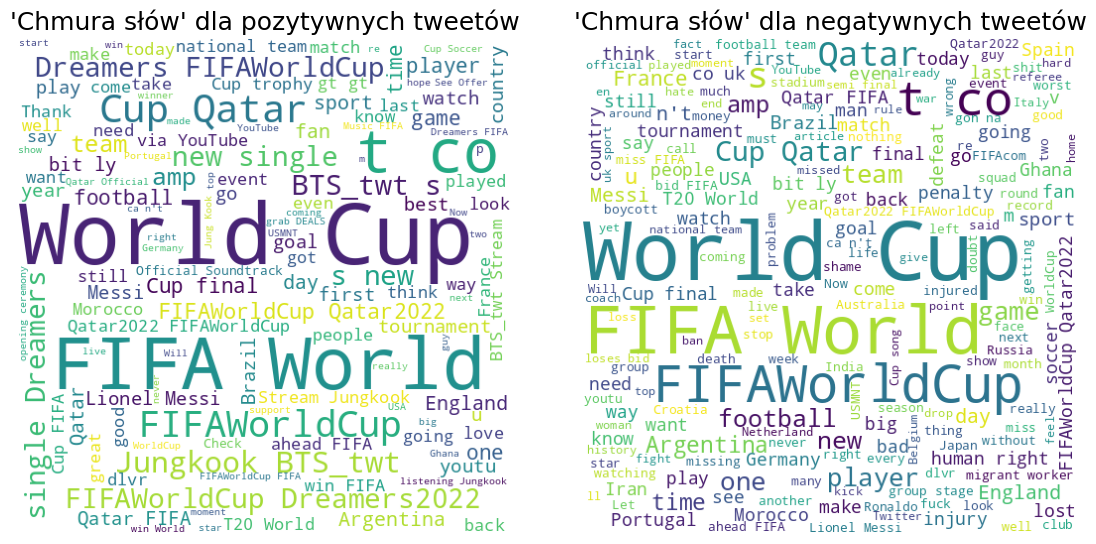

In [136]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_vader_tweets_joined_content = " ".join(
    [" ".join(x) for x in positive_vader_tweets["lemmatizedContent"]])

negative_vader_tweets_joined_content = " ".join(
    [" ".join(x) for x in negative_vader_tweets["lemmatizedContent"]])

positive_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(positive_vader_tweets_joined_content)

negative_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(negative_vader_tweets_joined_content)

fig = plt.figure(figsize=(12, 12), facecolor=None)

plt.subplot(1, 2, 1)
plt.title("'Chmura słów' dla pozytywnych tweetów", fontsize=18)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.subplot(1, 2, 2)
plt.title("'Chmura słów' dla negatywnych tweetów", fontsize=18)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=5)

plt.show()

#### Analiza czasowa


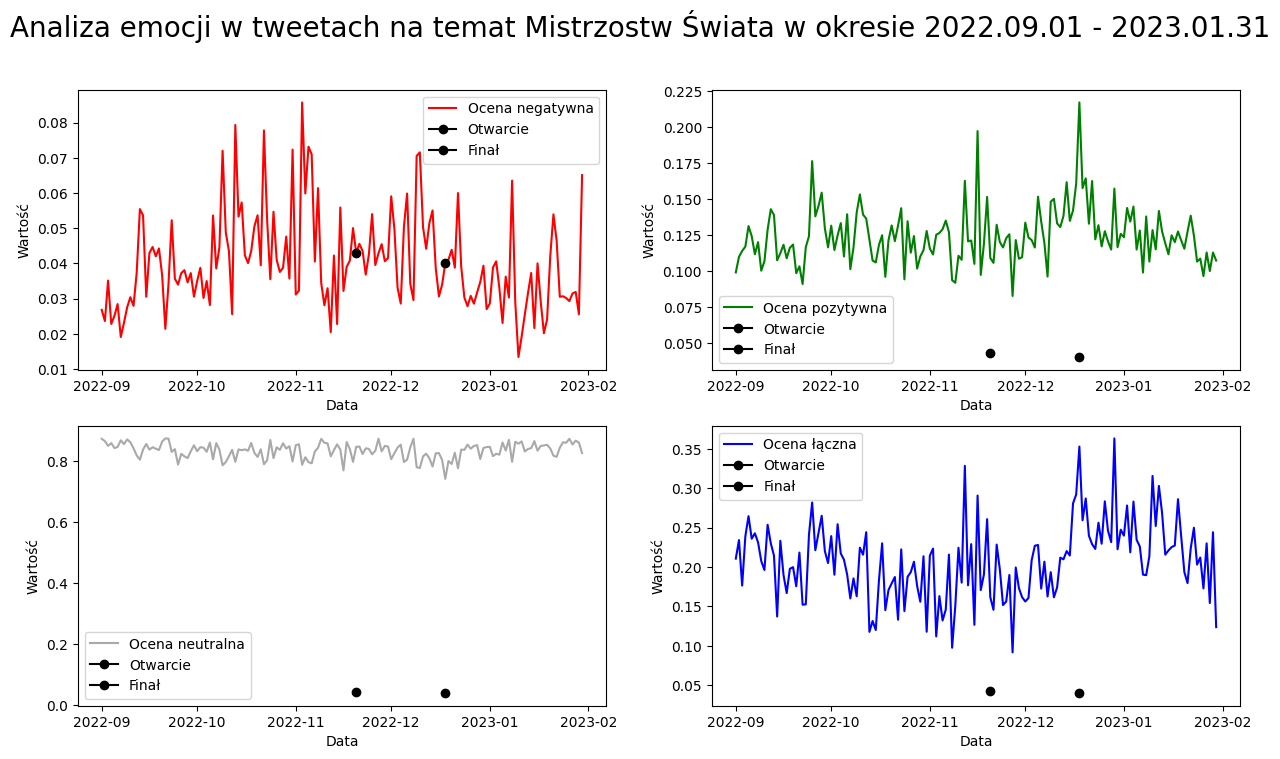

In [162]:
vader_tweets_grouped = vader_tweets[[
    "date", "vaderNeg", "vaderPos", "vaderNeu", "vaderCompound"]]

x = vader_tweets_grouped.groupby(["date"], as_index=False).mean()


def plot_vader_subplot(column_name, color, legend_name):
    plt.plot(x["date"], x[column_name], color=color)
    plt.ylabel("Wartość")
    plt.xlabel("Data")
    plt.plot(datetime.date(2022, 11, 20),
             x[x["date"] == datetime.date(2022, 11, 20)][column_name], marker="o", color="black")
    plt.plot(datetime.date(2022, 12, 18),
             x[x["date"] == datetime.date(2022, 12, 18)][column_name], marker="o", color="black")
    plt.legend([legend_name, "Otwarcie", "Finał"])


plt.figure(figsize=(15, 8))
plt.suptitle(
    "Analiza emocji w tweetach na temat Mistrzostw Świata w okresie 2022.09.01 - 2023.01.31", fontsize=20)
plt.subplot(2, 2, 1)
plot_vader_subplot("vaderNeg", "red", "Ocena negatywna")

plt.subplot(2, 2, 2)
plot_vader_subplot("vaderPos", "green", "Ocena pozytywna")

plt.subplot(2, 2, 3)
plot_vader_subplot("vaderNeu", "darkgrey", "Ocena neutralna")

plt.subplot(2, 2, 4)
plot_vader_subplot("vaderCompound", "blue", "Ocena łączna")

plt.show()

## Analiza za pomocą narzędzia Text2Emotion


### Analiza całościowa


In [138]:
import text2emotion as te


def prepare_t2e_data(tweets):
    t2e_tweets = tweets.copy()

    t2e_tweets["t2eResults"] = t2e_tweets.apply(
        lambda x: te.get_emotion(" ".join(x["lemmatizedContent"])), axis=1)

    t2e_tweets["t2eHappy"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Happy"], axis=1)
    t2e_tweets["t2eAngry"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Angry"], axis=1)
    t2e_tweets["t2eSurprise"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Surprise"], axis=1)
    t2e_tweets["t2eSad"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Sad"], axis=1)
    t2e_tweets["t2eFear"] = t2e_tweets.apply(
        lambda x: x["t2eResults"]["Fear"], axis=1)

    t2e_tweets = t2e_tweets.drop("t2eResults", axis=1)

    return t2e_tweets

In [140]:
t2e_tweets = import_prepared_data("data_wc_t2e.csv")

In [144]:
positive_t2e_tweets = t2e_tweets[t2e_tweets["t2eHappy"] + t2e_tweets["t2eSurprise"]
                                 >= t2e_tweets["t2eFear"] + t2e_tweets["t2eAngry"] + t2e_tweets["t2eSad"]]

negative_t2e_tweets = t2e_tweets[t2e_tweets["t2eHappy"] + t2e_tweets["t2eSurprise"]
                                 < t2e_tweets["t2eFear"] + t2e_tweets["t2eAngry"] + t2e_tweets["t2eSad"]]

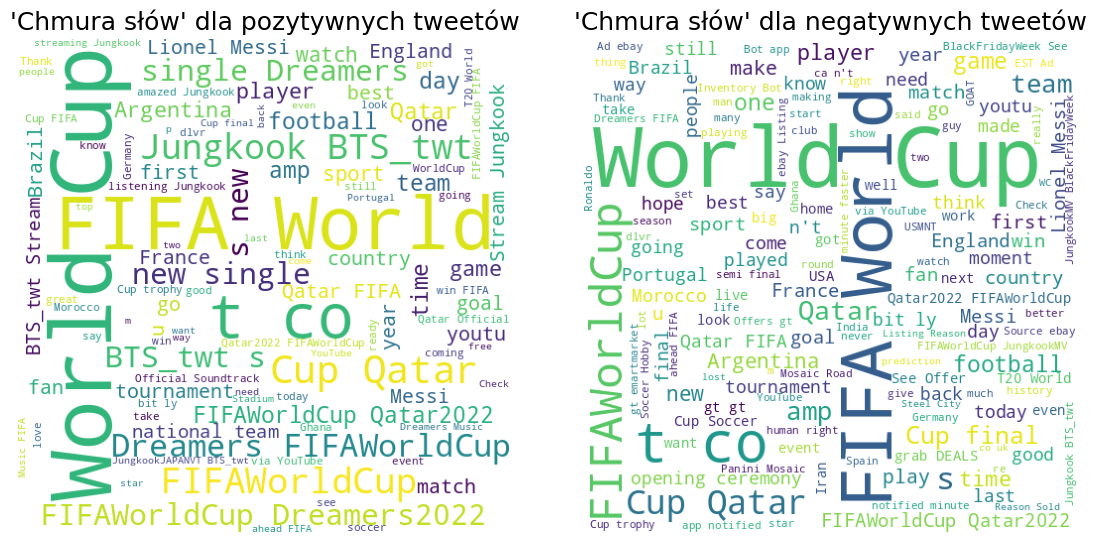

In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_t2e_tweets_joined_content = " ".join(
    [" ".join(x) for x in positive_t2e_tweets["lemmatizedContent"]])

negative_t2e_tweets_joined_content = " ".join(
    [" ".join(x) for x in negative_t2e_tweets["lemmatizedContent"]])

positive_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(positive_t2e_tweets_joined_content)

negative_wordcloud = WordCloud(width=500, height=500,
                               background_color='white',
                               min_font_size=10).generate(negative_t2e_tweets_joined_content)

fig = plt.figure(figsize=(12, 12), facecolor=None)

plt.subplot(1, 2, 1)
plt.title("'Chmura słów' dla pozytywnych tweetów", fontsize=18)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.subplot(1, 2, 2)
plt.title("'Chmura słów' dla negatywnych tweetów", fontsize=18)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad=5)

plt.show()

### Analiza czasowa


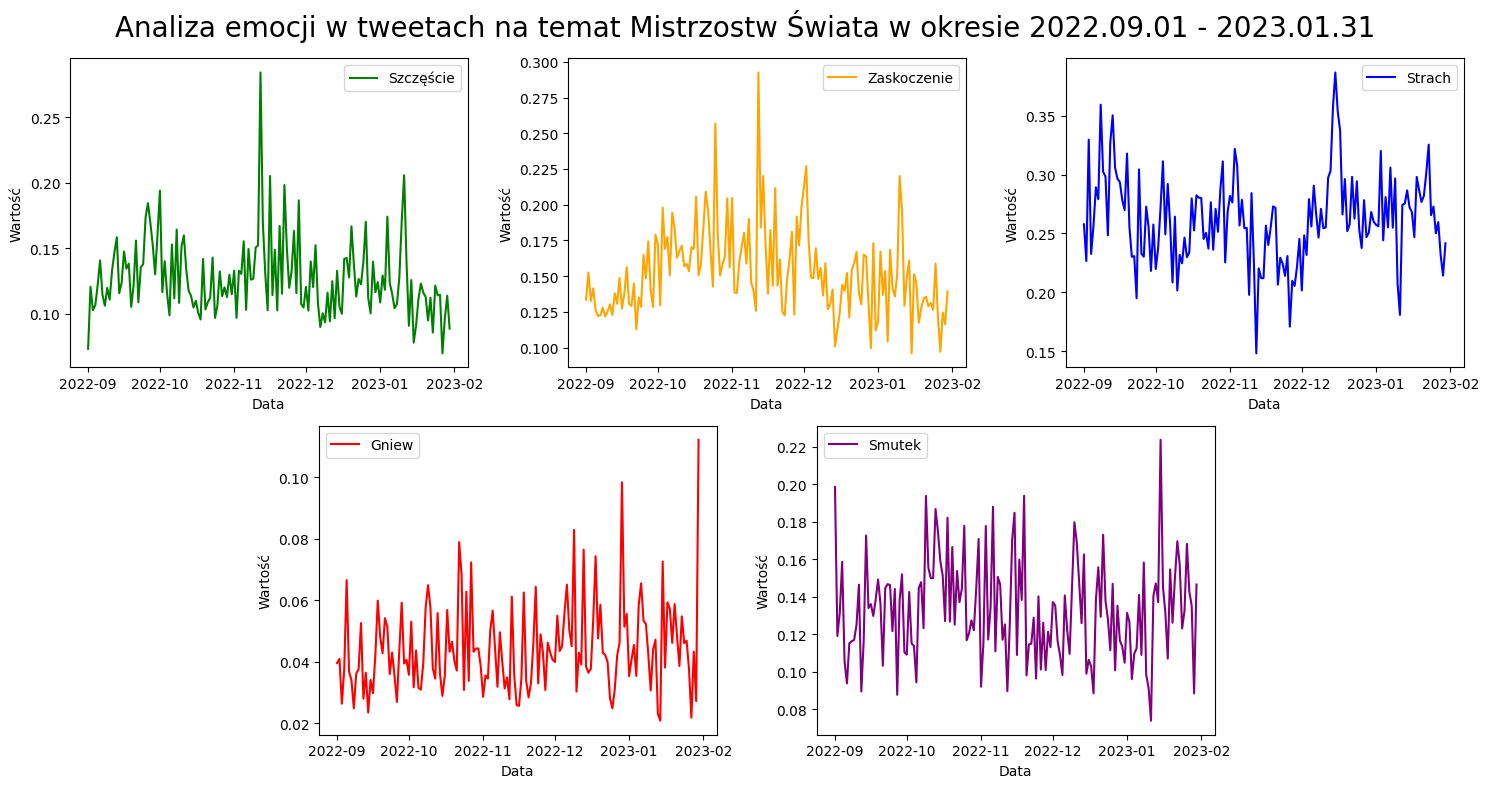

In [150]:
t2e_tweets_grouped = t2e_tweets[[
    "date", "t2eHappy", "t2eSurprise", "t2eFear", "t2eAngry", "t2eSad"]]

x = t2e_tweets_grouped.groupby(["date"], as_index=False).mean()

plt.figure(figsize=(15, 8))
plt.suptitle(
    "Analiza emocji w tweetach na temat Mistrzostw Świata w okresie 2022.09.01 - 2023.01.31", fontsize=20)
plt.subplot2grid((2, 6), (0, 0), colspan=2)
plt.plot(x["date"], x["t2eHappy"], color="green")
plt.ylabel("Wartość")
plt.xlabel("Data")
plt.legend(["Szczęście"])

plt.subplot2grid((2, 6), (0, 2), colspan=2)
plt.plot(x["date"], x["t2eSurprise"], color="orange")
plt.ylabel("Wartość")
plt.xlabel("Data")
plt.legend(["Zaskoczenie"])

plt.subplot2grid((2, 6), (0, 4), colspan=2)
plt.plot(x["date"], x["t2eFear"], color="blue")
plt.ylabel("Wartość")
plt.xlabel("Data")
plt.legend(["Strach"])

plt.subplot2grid((2, 6), (1, 1), colspan=2)
plt.plot(x["date"], x["t2eAngry"], color="red")
plt.ylabel("Wartość")
plt.xlabel("Data")
plt.legend(["Gniew"])

plt.subplot2grid((2, 6), (1, 3), colspan=2)
plt.plot(x["date"], x["t2eSad"], color="purple")
plt.ylabel("Wartość")
plt.xlabel("Data")
plt.legend(["Smutek"])

plt.tight_layout()
plt.show()

# Podsumowanie


# Bibliografia
